# Tree-Based Methods

In this chapter, we describe tree-based methods for regression and classiﬁcation.

Tree-based methods are simple and useful for interpretation. However, they typically are not competitive with the best supervised learning approaches, such as those seen in Chapters 6 and 7, in terms of prediction accuracy. We will see that combining a large number of trees can often result in dramatic improvements in prediction accuracy, at the expense of some loss in interpretation.

## The Basics of Decision Trees

### Regression Trees

#### Predicting Baseball Players’ Salaries Using Regression Trees

We use the ***Hitters*** data set to predict a baseball player’s *Salary* based on *Years* (the number of years that he has played in the major leagues) and *Hits* (the number of hits that he made in the previous year).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
# Remove the missing observations
Hitters = pd.read_csv('Hitters.csv').dropna()
Hitters

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,-Willie McGee,497,127,7,65,48,37,5,2703,806,...,379,311,138,N,E,325,9,3,700.0,N
318,-Willie Randolph,492,136,5,76,50,94,12,5511,1511,...,897,451,875,A,E,313,381,20,875.0,A
319,-Wayne Tolleson,475,126,3,61,43,52,6,1700,433,...,217,93,146,A,W,37,113,7,385.0,A
320,-Willie Upshaw,573,144,9,85,60,78,8,3198,857,...,470,420,332,A,E,1314,131,12,960.0,A


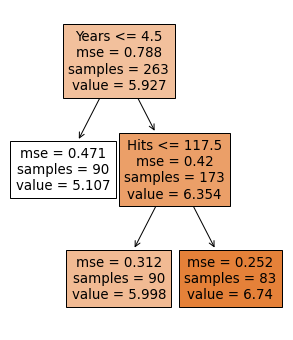

In [3]:
# Figure 8.1
X = Hitters[['Years','Hits']]
y = np.log(Hitters['Salary']) # Log-transform Salary has more of a typical bell-shape distribution.

dtr = DecisionTreeRegressor(max_leaf_nodes=3)
dtr.fit(X,y)
plt.figure(figsize=(5,6))
_ = plot_tree(dtr,feature_names=['Years','Hits'],class_names='Salary',filled=True)

The tree has two internal nodes and three terminal nodes, or ***leaves***. The number in each leaf is the mean of the response for the observations that fall there.

These three regions can be written as $R_1= \{X | Years<4.5 \} $, $R_2 = \{ X | Years>=4.5, Hits<117.5 \}$, and $R_3= \{ X | Years>=4.5, Hits>=117.5 \}$ .

In [4]:
# Find out the threshold to segment the trees
print(dtr.tree_.threshold)
years = dtr.tree_.threshold[0] # Segmentation on 'Years': 4.5
hits = dtr.tree_.threshold[2] # Segmentation on 'Hits': 117.5

[  4.5  -2.  117.5  -2.   -2. ]


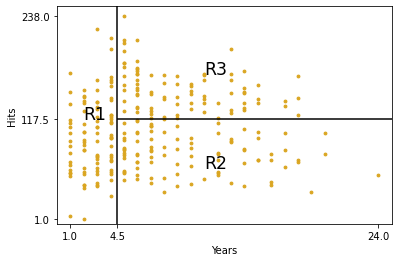

In [5]:
# Figure 8.2
plt.scatter(Hitters['Years'],Hitters['Hits'],color='goldenrod',s=8)
plt.xlabel('Years')
plt.ylabel('Hits')
plt.xlim(0,25)
plt.ylim(-5)
plt.xticks([1,4.5,24])
plt.yticks([1,117.5,238])
plt.vlines(years, ymin=-5, ymax=250)
plt.hlines(hits, xmin=years, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large')
plt.show()

The three-region partition for the Hitters data set from the regression tree illustrated in Figure 8.1.

#### Prediction via Stratiﬁcation of the Feature Space

The process of building a regression tree:
* We divide the predictor space — that is, the set of possible values for $X_1$, $X_2$,..., $X_p$ — into $J$ distinct and non-overlapping regions, $R_1$, $R_2$,..., $R_J$. 
* For every observation that falls into the region $R_j$, we make the same prediction, which is simply the mean of the response values for the training observations in $R_j$.

In theory, the regions could have any shape. However, we choose to divide the predictor space into high-dimensional rectangles, or boxes, for simplicity and for ease of interpretation of the resulting predictive model. The goal is to ﬁnd boxes $R_1$, $R_2$,..., $R_J$ that minimize the $RSS$, given by
$$\sum_{j=1}^{J} \sum_{i \in R_{j}}\left(y_{i}-\hat{y}_{R_{j}}\right)^{2}\tag{8.1}$$
where $\hat{y}_{R_{j}}$ is the mean response for the training observations within the $j$th box.

Unfortunately, it is computationally infeasible to consider every possible partition of the feature space into $J$ boxes. For this reason, we take a top-down, greedy approach that is known as ***recursive binary splitting (递归二元分裂)***.

In greater detail, for any $j$ and $s$, we deﬁne the pair of half-planes
$$
R_{1}(j, s)=\left\{X \mid X_{j}<s\right\} \text { and } R_{2}(j, s)=\left\{X \mid X_{j} \geq s\right\}\tag{8.2}
$$
and we seek the value of $j$ and $s$ that minimize the equation
$$
\sum_{i: x_{i} \in R_{1}(j, s)}\left(y_{i}-\hat{y}_{R_{1}}\right)^{2}+\sum_{i: x_{i} \in R_{2}(j, s)}\left(y_{i}-\hat{y}_{R_{2}}\right)^{2}\tag{8.3}
$$
where $\hat{y}_{R_{1}}$ is the mean response for the training observations in $R_{1}(j, s)$, and $\hat{y}_{R_{2}}$ is the mean response for the training observations in $\hat{y}_{R_{2}}$.

Next, we repeat the process, looking for the best predictor and best cutpoint in order to split the data further so as to minimize the $RSS$ within each of the resulting regions.

Once the regions $R_1$, $R_2$,..., $R_J$  have been created, we predict the response for a given test observation using the mean of the training observations in the region to which that test observation belongs.

A ﬁve-region example of this approach is shown in Figure 8.3.
<img src="img/8.3.jpg" style="zoom:50%" />
Top Left: A partition of two-dimensional feature space that could not result from recursive binary splitting. 

Top Right: The output of recursive binary splitting on a two-dimensional example. 

Bottom Left: A tree corresponding to the partition in the top right panel. 

Bottom Right: A perspective plot of the prediction surface corresponding to that tree.

#### Tree Pruning

The process described above may produce good predictions on the training set, but is likely to ***overﬁt*** the data, leading to poor test set performance. This is because the resulting tree might be too complex. A smaller tree with fewer splits (that is, fewer regions $R_1$, $R_2$,..., $R_J$) might lead to lower variance and better interpretation at the cost of a little bias.

Therefore, a better strategy is to grow a very large tree $T_0$, and then ***prune it back*** in order to obtain a subtree. How do we determine the best way to prune the tree?

***Cost complexity pruning (代价复杂度剪枝)*** — also known as weakest link pruning — gives us a way to do just this. Rather than considering every possible subtree, we consider a sequence of trees indexed by a nonnegative tuning parameter $\alpha$. For each value of $\alpha$ there corresponds a subtree $T \subset T_{0}$ such that
$$
\sum_{m=1}^{|T|} \sum_{x_{i} \in R_{m}}\left(y_{i}-\hat{y}_{R_{m}}\right)^{2}+\alpha|T|\tag{8.4}
$$
is as small as possible. Here $|T|$ indicates the number of terminal nodes of the tree $T$, $R_m$ is the rectangle (i.e. the subset of predictor space) corresponding to the $m$th terminal node, and $\hat{y}_{R_{m}}$ is the mean of the training observations in $R_m$. 

The tuning parameter $\alpha$ controls a trade-oﬀ between the subtree’s complexity and its ﬁt to the training data. When $\alpha = 0$, then the subtree $T$ will simply equal $T_0$ , because then (8.4) just measures the training error. However, as $\alpha$ increases, there is a price to pay for having a tree with many terminal nodes, and so the quantity (8.4) will tend to be minimized for a smaller subtree.

Equation 8.4 is reminiscent of the lasso (6.7) from Chapter 6, in which a similar formulation was used in order to control the complexity of a linear model.

Reference: 
1. [How to choose 𝛼 in cost-complexity pruning?](https://stats.stackexchange.com/questions/193538/how-to-choose-alpha-in-cost-complexity-pruning)
2. [Post pruning decision trees with cost complexity pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)

***
**Algorithm 8.1** *Building a Regression Tree*
***
1. Use ***recursive binary splitting*** to grow a large tree on the training data, stopping only when each terminal node has fewer than some minimum number of observations.
2. Apply ***cost complexity pruning*** to the large tree in order to obtain a sequence of best subtrees, as a function of $\alpha$.
3. Use K-fold cross-validation to choose $\alpha$. For each $k = 1,..., K$:  
(a) Repeat Steps 1 and 2 on the $\frac{K-1}{K}$th fraction of the training data, excluding the $k$th fold.  
(b) Evaluate the mean squared prediction error on the data in the left-out $k$th fold, as a function of $\alpha$.  
Average the results, and pick $\alpha$ to minimize the average error.
4. Return the subtree from Step 2 that corresponds to the chosen value of $\alpha$.
***

Figures 8.4 and 8.5 display the results of ﬁtting and pruning a regression tree on the ***Hitters*** data, using nine of the features. 

First, we randomly divided the data set in half, yielding 132 observations in the training set and 131 observations in the test set. 
<img src="img/8.4.jpg" style="zoom:50%" />
We then built a large regression tree on the training data and varied $\alpha$ in (8.4) in order to create subtrees with different numbers of terminal nodes.
<img src="img/8.5.jpg" style="zoom:50%" />

### Classiﬁcation Trees

However, in the classiﬁcation setting, $RSS$ cannot be used as a criterion for making the binary splits. A natural alternative to $RSS$ is the ***classiﬁcation error rate***. Since we plan to assign an observation in a given region to the most commonly occurring class of training observations in that region, the classiﬁcation error rate is simply the fraction of the training observations in that region that do not belong to the most common class:
$$
E=1-\max _{k}\left(\hat{p}_{m k}\right)\tag{8.5}
$$
Here $\hat{p}_{m k}$ represents the proportion of training observations in the $m$th region that are from the $k$th class.

However, it turns out that classiﬁcation error is not suﬃciently sensitive for tree-growing, and in practice two other measures are preferable.

The ***Gini index*** is deﬁned by
$$
G=\sum_{k=1}^{K} \hat{p}_{m k}\left(1-\hat{p}_{m k}\right)\tag{8.6}
$$
a measure of total variance across the $K$ classes. It is not hard to see that the Gini index takes on a small value if all of the $\hat{p}_{m k}$’s are close to zero or one. For this reason the Gini index is referred to as a measure of node ***purity*** — a small value indicates that a node contains predominantly observations from a single class.

An alternative to the Gini index is ***cross-entropy***, given by
$$
D=-\sum_{k=1}^{K} \hat{p}_{m k} \log \hat{p}_{m k}\tag{8.7}
$$
One can show that the cross-entropy will take on a value near zero if the $\hat{p}_{m k}$’s are all near zero or near one. Therefore, like the Gini index, the cross-entropy will take on a small value if the $m$th node is pure. 

In fact, it turns out that the Gini index and the cross-entropy are quite similar numerically.

When building a classiﬁcation tree, either the Gini index or the crossentropy are typically used to evaluate the quality of a particular split, but the classiﬁcation error rate is preferable if prediction accuracy of the ﬁnal pruned tree is the goal.

The ***Heart*** data set contains a binary outcome AHD for 303 patients who presented with chest pain, the outcome value of *Yes* indicates the presence of heart disease based on an angiographic test, while *No* means no heart disease.

In [6]:
Heart = pd.read_csv('Heart.csv',index_col=0).dropna()
Heart

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,asymptomatic,140,241,0,0,123,1,0.2,2,0.0,reversable,Yes
299,45,1,typical,110,264,0,0,132,0,1.2,2,0.0,reversable,Yes
300,68,1,asymptomatic,144,193,1,0,141,0,3.4,2,2.0,reversable,Yes
301,57,1,asymptomatic,130,131,0,0,115,1,1.2,2,1.0,reversable,Yes


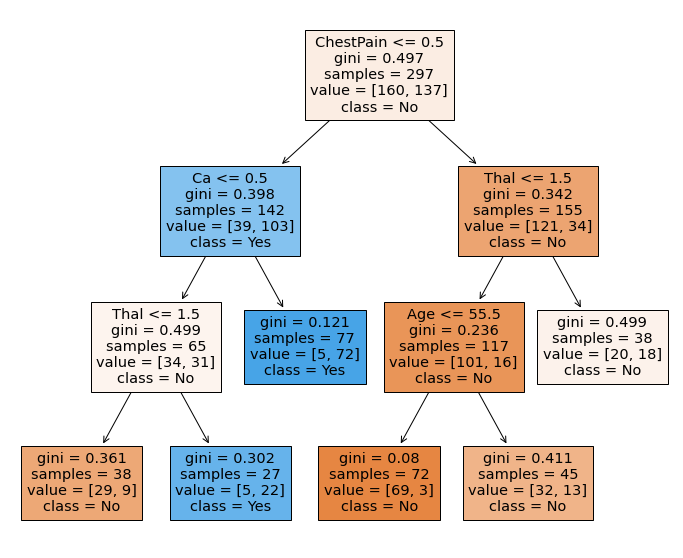

In [7]:
# Figure 8.6
# First convert qualitative columns into incremental value
le = LabelEncoder()
qualitative_columns = ['ChestPain','Thal','AHD']

for column in qualitative_columns:
    Heart[column] = le.fit_transform(Heart[column])

# Do the classfication
X = Heart.drop('AHD',axis=1)
y = Heart['AHD']

dtc = DecisionTreeClassifier(max_leaf_nodes=6)
dtc.fit(X,y)
fig = plt.figure(figsize=(12,10))
_ = plot_tree(dtc,feature_names=X.columns,class_names=['No','Yes'],filled=True)

Figure 8.6 has a surprising characteristic: some of the splits yield two terminal nodes that have the ***same predicted value***.
The split is performed because it leads to increased *node purity*.

### Trees Versus Linear Models

Linear regression assumes a model of the form
$$
f(X)=\beta_{0}+\sum_{j=1}^{p} X_{j} \beta_{j}\tag{8.8}
$$
whereas regression trees assume a model of the form
$$
f(X)=\sum_{m=1}^{M} c_{m} \cdot 1_{\left(X \in R_{m}\right)}\tag{8.9}
$$
where $R_1,...,R_M$ represent a partition of feature space, as in Figure 8.3.

Which model is better? It depends on the problem at hand. If the relationship between the features and the response is well approximated by a linear model as in (8.8), then an approach such as linear regression will likely work well. If instead there is a highly nonlinear and complex relationship between the features and the response as indicated by model (8.9), then decision trees may outperform classical approaches.

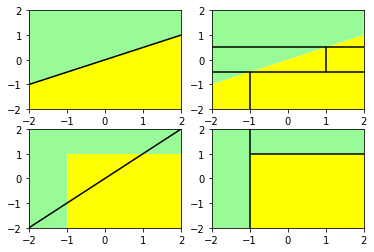

In [8]:
# Figure 8.7
# Subfigure 1
plt.subplot(221)
x=[-2,-1,0,1,2]
y=[-1,-0.5,0,0.5,1]

plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.fill_between(x,y,2,facecolor='palegreen')
plt.fill_between(x,-2,y,facecolor='yellow')

plt.plot(x,y,c='black')

# Subfigure 2
plt.subplot(222)
x=[-2,-1,0,1,2]
y=[-1,-0.5,0,0.5,1]

plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.fill_between(x,y,2,facecolor='palegreen')
plt.fill_between(x,-2,y,facecolor='yellow')
plt.vlines(x=-1,ymin=-2, ymax=-0.5)
plt.vlines(x=1,ymin=-0.5, ymax=0.5)
plt.hlines(y=-0.5,xmin=-2, xmax=2)
plt.hlines(y=0.5,xmin=-2, xmax=2)

# Subfigure 3
plt.subplot(223)
x=[-1,2]

plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.fill_between(x,-2,1,facecolor='yellow')
plt.fill_between([-2,-1],-2,2,facecolor='palegreen')
plt.fill_between([-1,2],1,2,facecolor='palegreen')
plt.plot([-2,2],[-2,2],color='black')

# Subfigure 4
plt.subplot(224)
x=[-1,2]

plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.fill_between(x,-2,1,facecolor='yellow')
plt.fill_between([-2,-1],-2,2,facecolor='palegreen')
plt.fill_between([-1,2],1,2,facecolor='palegreen')
plt.vlines(x=-1,ymin=-2,ymax=2)
plt.hlines(y=1,xmin=-1, xmax=2)

plt.show()

Of course, other considerations beyond simply test error may come into play in selecting a statistical learning method; for instance, in certain settings, prediction using a tree may be preferred for the sake of interpretability and visualization.

### Advantages and Disadvantages of Trees

Advantages:
1. Trees are very easy to explain to people. In fact, they are even easier to explain than linear regression!
2. Some people believe that decision trees more closely mirror human decision-making than do the regression and classiﬁcation approaches seen in previous chapters.
3. Trees can be displayed graphically, and are easily interpreted even by a non-expert (especially if they are small).
4. Trees can easily handle qualitative predictors without the need to create dummy variables.

Disadvantage:
1. Unfortunately, trees generally do not have the same level of predictive accuracy as some of the other regression and classiﬁcation approaches seen in this book.

However, by aggregating many decision trees, using methods like ***bagging***, ***random forests***, and ***boosting***, the predictive performance of trees can be substantially improved. We introduce these concepts in the next section.

## Lab: Decision Trees

### Fitting Classiﬁcation Trees

In [9]:
Carseats = pd.read_csv('Carseats.csv')

# Sales is a continuous variable, and so we begin by recoding it as a binary variable
Carseats['High'] = Carseats['Sales'].apply(lambda x:1 if x>8 else 0)
Carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes,1
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes,0
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes,0
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes,0


In [10]:
qualitative_columns = ['ShelveLoc','Urban','US']

for column in qualitative_columns:
    Carseats[column] = le.fit_transform(Carseats[column])

# Do the Classification
X = Carseats.drop(['Sales','High'],axis=1)
y = Carseats['High']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train,y_train)
print('Total accuracy: %f'%dtc.score(X,y))
print(classification_report(y, dtc.predict(X)))

Total accuracy: 0.855000
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       236
           1       0.86      0.77      0.81       164

    accuracy                           0.85       400
   macro avg       0.86      0.84      0.85       400
weighted avg       0.86      0.85      0.85       400



In [11]:
# Other features
print('Feature importance: %s'%dict(zip(X.columns, dtc.feature_importances_)))
print('\nTerminal nodes: %f'%dtc.get_n_leaves())
print('\nDepth: %f'%dtc.get_depth())

Feature importance: {'CompPrice': 0.15715126285408312, 'Income': 0.09045326430884951, 'Advertising': 0.13235128799922508, 'Population': 0.02000293376361865, 'Price': 0.35091489074304477, 'ShelveLoc': 0.07247741134828184, 'Age': 0.11274134265843128, 'Education': 0.06390760632446577, 'Urban': 0.0, 'US': 0.0}

Terminal nodes: 38.000000

Depth: 9.000000


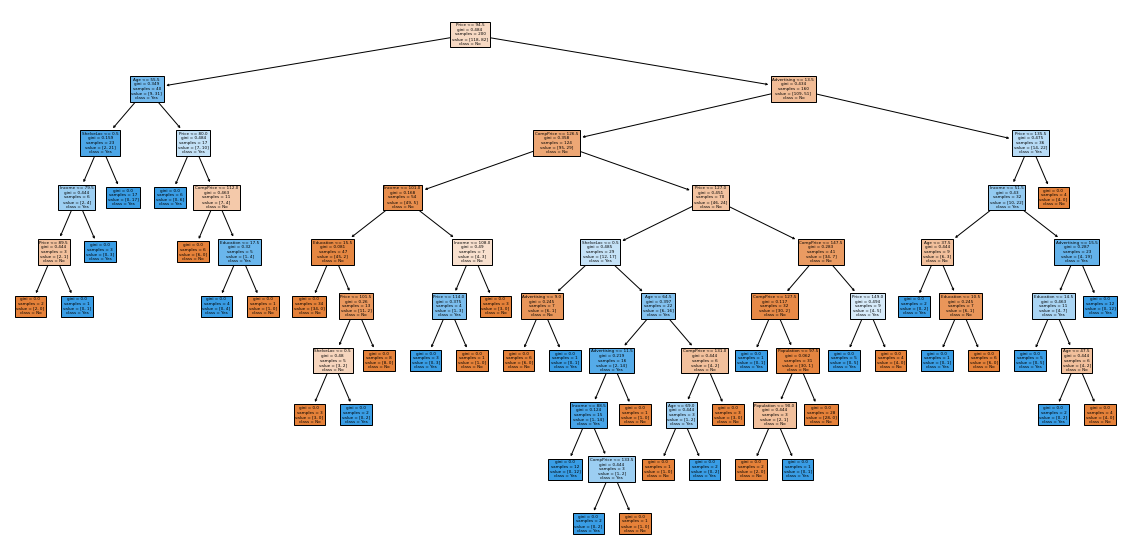

In [12]:
# The unpruned tree figure
fig = plt.figure(figsize=(20,10))
_ = plot_tree(dtc,feature_names=X.columns,class_names=['No','Yes'],filled=True)

In [13]:
# Prediction accuracy
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True,No,Yes
Predicted,,
No,97,37
Yes,21,45


In [14]:
print('正确率为：%f'%((cm.iloc[0,0]+cm.iloc[1,1])/200)) # Manually calculated
print('Test Accuracy: %f'%dtc.score(X_test,y_test)) # Automatically calculated

正确率为：0.710000
Test Accuracy: 0.710000


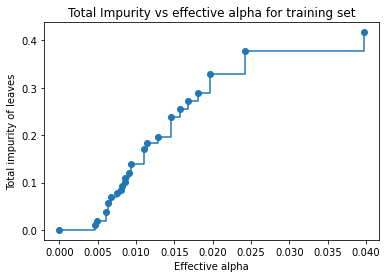

In [15]:
# Post pruning decision trees with cost complexity pruning

#In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node.
path = dtc.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas[:-1], path.impurities[:-1]

plt.plot(ccp_alphas,impurities, marker='o', drawstyle="steps-post")
plt.xlabel('Effective alpha')
plt.ylabel('Total impurity of leaves')
plt.title('Total Impurity vs effective alpha for training set')
plt.show()

In [16]:
dtcs = []
for ccp_alpha in ccp_alphas:
    dtc = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dtc.fit(X_train, y_train)
    dtcs.append(dtc)

nodes = [dtc.get_n_leaves() for dtc in dtcs]
depth = [dtc.get_depth() for dtc in dtcs]

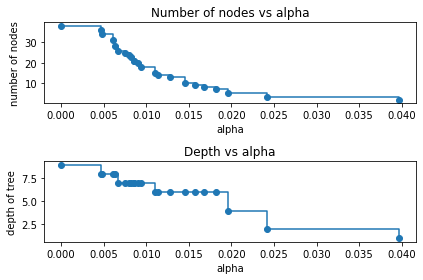

In [17]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, nodes, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

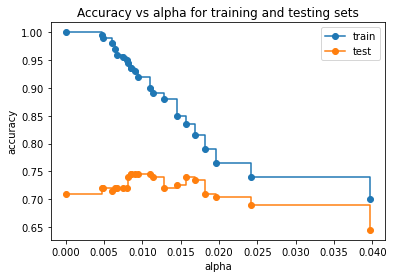

In [18]:
train_scores = [dtc.score(X_train, y_train) for dtc in dtcs]
test_scores = [dtc.score(X_test, y_test) for dtc in dtcs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [19]:
# Find the highest test score
optimal = np.argmax(test_scores)
print('The highest accuracy is: %f'%test_scores[optimal], '\nThe CCP-alpha is: %f'%ccp_alphas[optimal], 
      '\nNumber of leaves nodes: %f'%nodes[optimal], '\nThe depth is: %f'%depth[optimal])

The highest accuracy is: 0.745000 
The CCP-alpha is: 0.008571 
Number of leaves nodes: 21.000000 
The depth is: 7.000000


### Fitting Regression Trees

In [20]:
Boston = pd.read_csv('Boston.csv').dropna()
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [21]:
# Do the regression
X = Boston.drop('medv',axis=1)
y = Boston['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
print('Total accuracy: %f'%dtr.score(X,y))

Total accuracy: 0.854356


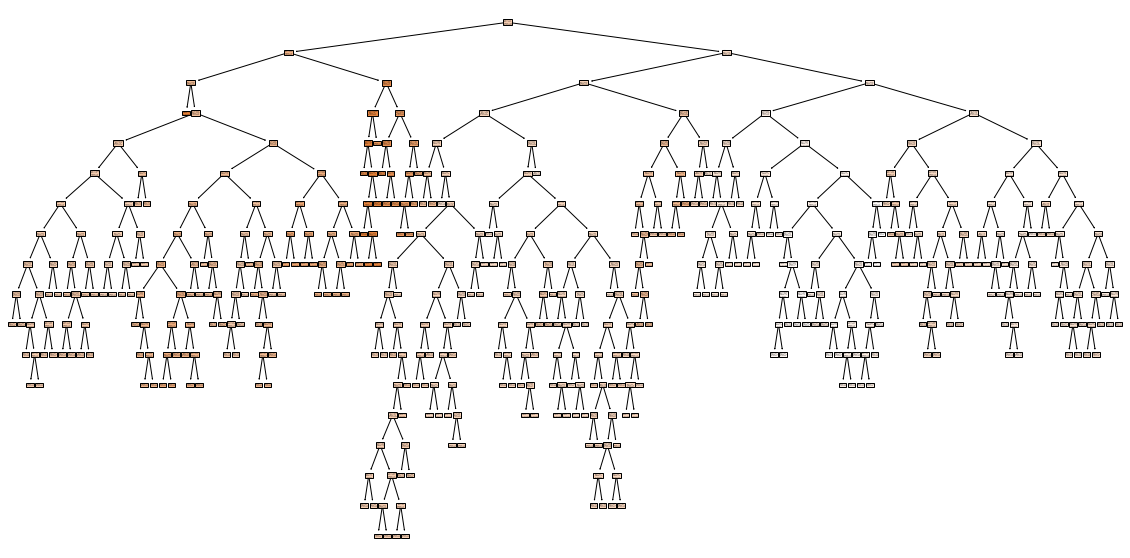

In [22]:
# The unpruned tree figure
fig = plt.figure(figsize=(20,10))
_ = plot_tree(dtr,feature_names=X.columns,class_names=['No','Yes'],filled=True)

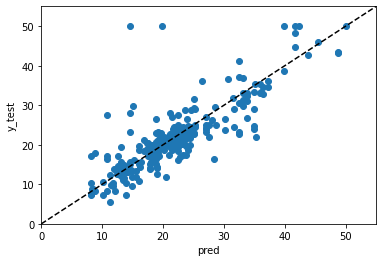

In [23]:
# Compare y_pred with the real y_test
pred = dtr.predict(X_test)
plt.scatter(pred, y_test)
plt.plot([0,100],[0,100],'--k')
plt.xlim(0,55)
plt.ylim(0,55)
plt.xlabel('pred')
plt.ylabel('y_test')
plt.show()

In [24]:
# MSE
mean_squared_error(y_test, pred)

24.590434782608693

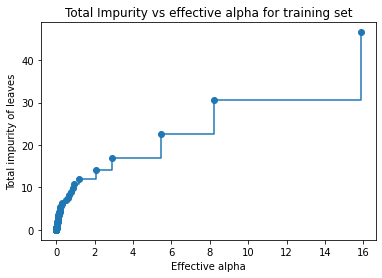

In [25]:
# Post pruning decision trees with cost complexity pruning

#In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node.
path = dtr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas[:-1], path.impurities[:-1]

plt.plot(ccp_alphas,impurities, marker='o', drawstyle="steps-post")
plt.xlabel('Effective alpha')
plt.ylabel('Total impurity of leaves')
plt.title('Total Impurity vs effective alpha for training set')
plt.show()

In [26]:
dtrs = []
for ccp_alpha in ccp_alphas:
    dtr = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    dtr.fit(X_train, y_train)
    dtrs.append(dtr)

nodes = [dtr.get_n_leaves() for dtr in dtrs]
depth = [dtr.get_depth() for dtr in dtrs]

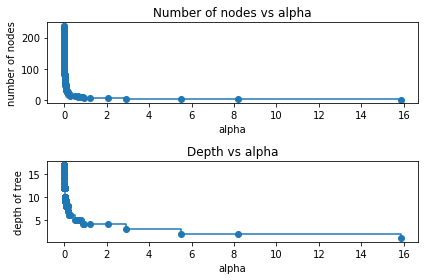

In [27]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, nodes, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

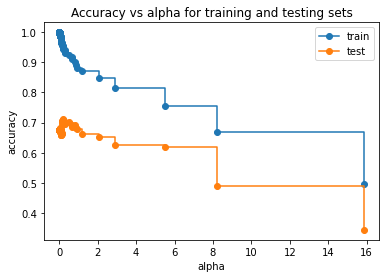

In [28]:
train_scores = [dtr.score(X_train, y_train) for dtr in dtrs]
test_scores = [dtr.score(X_test, y_test) for dtr in dtrs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [29]:
# Find the highest test score
optimal = np.argmax(test_scores)
print('The highest accuracy is: %f'%test_scores[optimal], '\nThe CCP-alpha is: %f'%ccp_alphas[optimal], 
      '\nNumber of leaves nodes: %f'%nodes[optimal], '\nThe depth is: %f'%depth[optimal])

The highest accuracy is: 0.710797 
The CCP-alpha is: 0.174563 
Number of leaves nodes: 23.000000 
The depth is: 8.000000
